<a href="https://colab.research.google.com/github/maximum4645/ComputerVision/blob/main/object_detection_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

In [1]:
import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import random_split, Subset
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import seaborn as sns
import shutil
import os
import random

In [2]:
# Define the transform
transform = T.Compose([T.ToTensor()])

# Download the dataset
dataset = torchvision.datasets.VOCDetection(root='.', year='2012', image_set='trainval', download=True, transform=transform)

# Define the fraction of the dataset you want to use
fraction = 0.3

# Get a list of indices and shuffle them
indices = list(range(len(dataset)))
random.shuffle(indices)

# Select a subset of indices
subset_indices = indices[:int(len(indices) * fraction)]

# Create the subset dataset
subset_dataset = Subset(dataset, subset_indices)

# Split the subset into train and test sets
train_size = int(0.8 * len(subset_dataset))
test_size = len(subset_dataset) - train_size
train_set, test_set = random_split(subset_dataset, [train_size, test_size])

print('Number of train set :', len(train_set))
print('Number of test set :', len(test_set))

import xml.etree.ElementTree as ET

def extract_classes_from_voc_annotations(annotations_path):
    classes = set()
    for annotation_file in os.listdir(annotations_path):
        if annotation_file.endswith('.xml'):
            tree = ET.parse(os.path.join(annotations_path, annotation_file))
            root = tree.getroot()
            for obj in root.findall('object'):
                class_name = obj.find('name').text
                classes.add(class_name)
    return sorted(classes)

annotations_path = '/content/VOCdevkit/VOC2012/Annotations'
class_names = extract_classes_from_voc_annotations(annotations_path)
class_names

100%|██████████| 1999639040/1999639040 [01:38<00:00, 20237805.92it/s]


Extracting ./VOCtrainval_11-May-2012.tar to .
Number of train set : 2769
Number of test set : 693


['aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

# Model : YOLOv8

In [3]:
!pip install ultralytics
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [4]:
from ultralytics import YOLO

# Load a pretrained YOLO model
model_1 = YOLO('yolov8n.pt')  # or yolov8s.pt, yolov8m.pt, yolov8l.pt, yolov8x.pt
model_1

100%|██████████| 6.25M/6.25M [00:00<00:00, 147MB/s]


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

## Converting to YOLO format

In [5]:
images_path = './VOCdevkit/VOC2012/JPEGImages'
annotations_path = './VOCdevkit/VOC2012/Annotations'
train_path = './VOCdevkit/VOC2012/train'
val_path = './VOCdevkit/VOC2012/val'

# Create directories if they don't exist
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

In [6]:
import os
import shutil
import xml.etree.ElementTree as ET

def format_yolo(dataset, indices, img_src_dir, annotations_src_dir, dest_dir):
    os.makedirs(dest_dir, exist_ok=True)
    for e in dataset:

        img_filename = e[1]['annotation']['filename']
        voc_annotation_filename = img_filename.replace('.jpg', '.xml')

        img_path = os.path.join(img_src_dir, img_filename)
        annotations_path = os.path.join(annotations_src_dir, voc_annotation_filename)

        # Copy the image file
        shutil.copy(img_path, dest_dir)

        tree = ET.parse(annotations_path)
        root = tree.getroot()

        width = int(root.find('size/width').text)
        height = int(root.find('size/height').text)

        # Create the YOLO formatted annotation file
        txt_filename = voc_annotation_filename.replace('.xml', '.txt')
        txt_path = os.path.join(dest_dir, txt_filename)
        with open(txt_path, 'w') as f:
            for obj in root.findall('object'):
                label = obj.find('name').text
                if label in class_names:
                    label_idx = class_names.index(label)
                    bbox = obj.find('bndbox')
                    x_min = int(float(bbox.find('xmin').text))
                    y_min = int(float(bbox.find('ymin').text))
                    x_max = int(float(bbox.find('xmax').text))
                    y_max = int(float(bbox.find('ymax').text))

                    x_center = (x_min + x_max) / 2 / width
                    y_center = (y_min + y_max) / 2 / height
                    bbox_width = (x_max - x_min) / width
                    bbox_height = (y_max - y_min) / height

                    f.write(f"{label_idx} {x_center} {y_center} {bbox_width} {bbox_height}\n")

# Train set
train_indices = [subset_indices[i] for i in train_set.indices]
format_yolo(train_set, train_indices, images_path, annotations_path, train_path)

# Test set
test_indices = [subset_indices[i] for i in test_set.indices]
format_yolo(test_set, test_indices, images_path, annotations_path, val_path)

# Check if correctly done
print('Number of files in train :', len(os.listdir(train_path)))
print('Number of files in val :', len(os.listdir(val_path)))

# Data paths
# Define the content of the data.yaml file
data_yaml_content = f"""
train: /content/VOCdevkit/VOC2012/train
val: /content/VOCdevkit/VOC2012/val

nc: {len(class_names)}  # Number of classes
names: {class_names}
"""

# Write the content to a file
with open('data.yaml', 'w') as file:
    file.write(data_yaml_content)

# Verify the content
!cat data.yaml

Number of files in train : 5538
Number of files in val : 1386

train: /content/VOCdevkit/VOC2012/train
val: /content/VOCdevkit/VOC2012/val

nc: 20  # Number of classes
names: ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


# Prediction

## Evaluation before training

In [7]:
import time

start_time = time.time()

results_before = model_1.val(data='data.yaml')

end_time = time.time()

total_time = end_time - start_time
print(f"Total validation time: {total_time:.2f} seconds")

print(list(results_before.names.values()))
print()
print(results_before.results_dict)
print()
print(results_before.speed)

Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 95.8MB/s]
val: Scanning /content/VOCdevkit/VOC2012/val... 693 images, 0 backgrounds, 0 corrupt: 100%|██████████| 693/693 [00:00<00:00, 2022.04it/s]

val: New cache created: /content/VOCdevkit/VOC2012/val.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:12<00:00,  3.44it/s]


                   all        693       1998      0.189      0.077     0.0835     0.0656
                person         37         52          0          0   5.83e-05    2.9e-05
               bicycle         35         43      0.858      0.698      0.783      0.584
                   car         53         73          0          0   0.000217    0.00013
            motorcycle         33         82          0          0   0.000914   0.000688
              airplane         60         98          0          0    0.00043   0.000172
                   bus         32         57      0.923      0.841      0.851      0.701
                 train         85        188          0          0     0.0204     0.0172
                 truck         70         81          0          0          0          0
                  boat         68        161          0          0      0.001   0.000778
         traffic light         22         41          0          0          0          0
          fire hydran

Confusion Matrix shape: (81, 81)
Number of classes: 80
Number of classes: 81


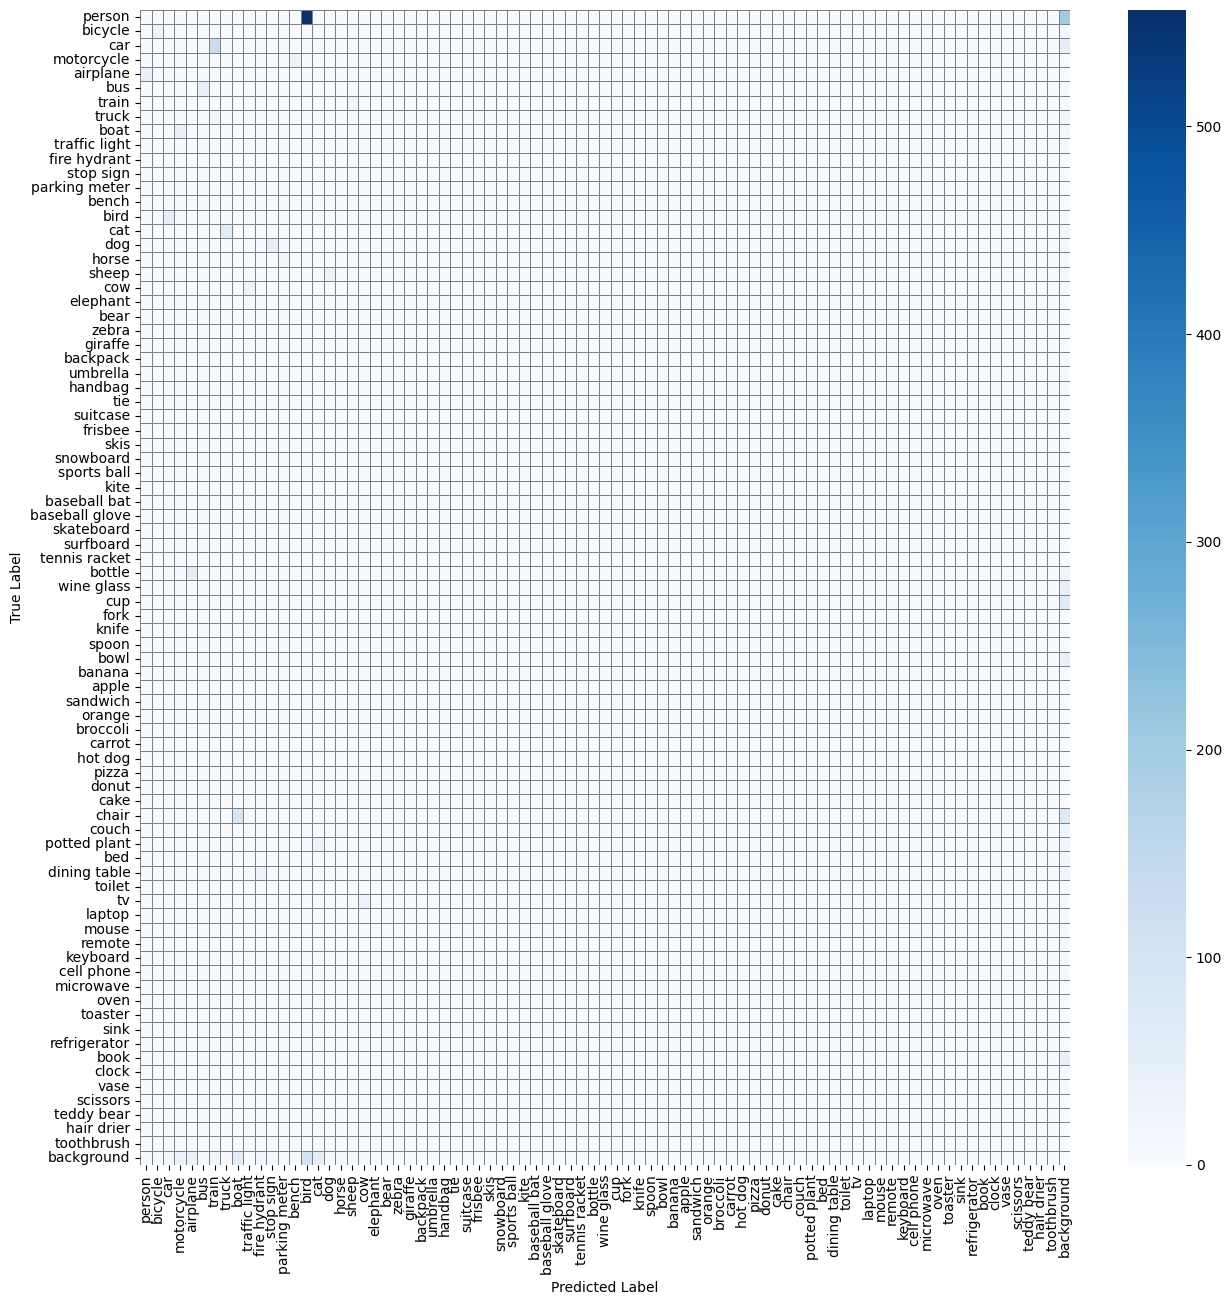

In [8]:
confusion_matrix = results_before.confusion_matrix.matrix
print("Confusion Matrix shape:", confusion_matrix.shape)
classes = list(results_before.names.values())
print("Number of classes:", len(classes))
if 'background' not in classes:
    classes.append('background')
print("Number of classes:", len(classes))

plt.figure(figsize=(15, 15))
sns.heatmap(confusion_matrix, annot=False, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes, linewidths=0.5, linecolor='gray')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)
plt.show()

## Visualization before training

100%|██████████| 134k/134k [00:00<00:00, 46.6MB/s]

image 1/1 /content/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 57.3ms
Speed: 2.5ms preprocess, 57.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


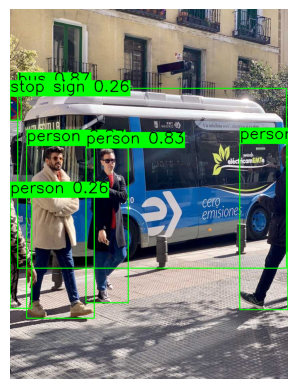

In [9]:
import cv2

results = model_1("https://ultralytics.com/images/bus.jpg")

# Retrieve the first result
result = results[0]

# Retrieve the image with detected bounding boxes
img = result.orig_img

# Define font size and thickness
font_scale = 1.5
font_thickness = 2

# Draw the bounding boxes and labels on the image
for box in result.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    label = result.names[int(box.cls[0])]
    confidence = box.conf[0]

    # Draw bounding box
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Draw label and confidence
    label_text = f"{label} {confidence:.2f}"
    (label_width, label_height), baseline = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
    cv2.rectangle(img, (x1, y1 - label_height - baseline), (x1 + label_width, y1), (0, 255, 0), cv2.FILLED)
    cv2.putText(img, label_text, (x1, y1 - baseline), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), font_thickness)

# Convert the image from BGR to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image with detections
plt.imshow(img_rgb)
plt.axis('off')  # Turn off axis
plt.show()


0: 640x640 1 bottle, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


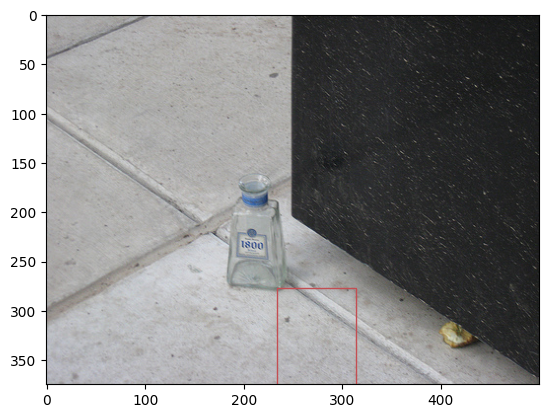


0: 640x640 1 cat, 12.2ms
Speed: 0.0ms preprocess, 12.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


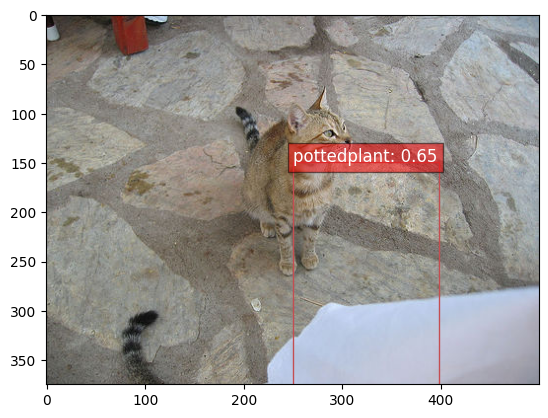


0: 640x640 1 cat, 1 dog, 1 bed, 10.8ms
Speed: 0.0ms preprocess, 10.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


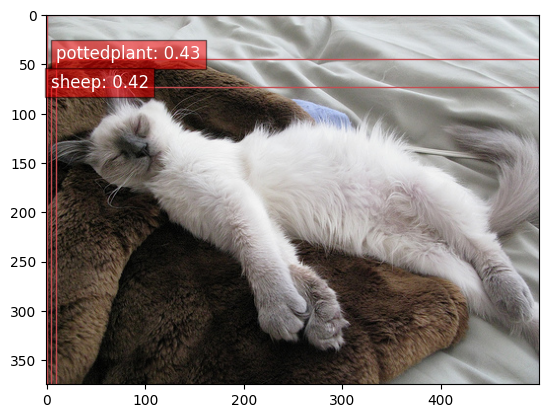


0: 640x640 1 cat, 10.4ms
Speed: 0.0ms preprocess, 10.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


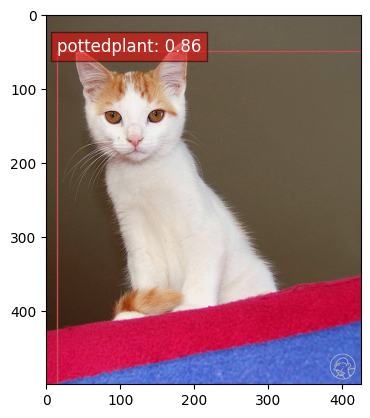


0: 640x640 6 persons, 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


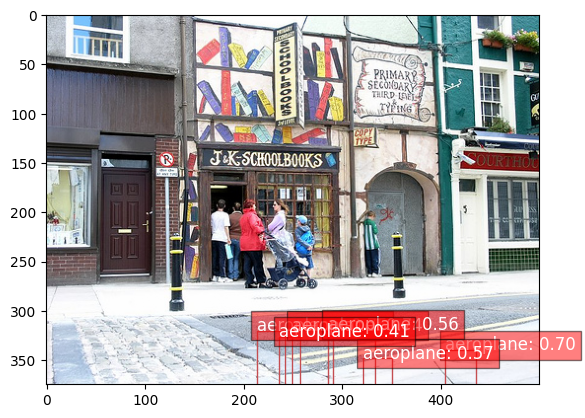

In [10]:
import matplotlib.patches as patches
import random

def visualize_detection(image, results, categories):
    fig, ax = plt.subplots(1)
    ax.imshow(image.permute(1, 2, 0))

    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy()  # Bounding box coordinates
        scores = result.boxes.conf.cpu().numpy()  # Confidence scores
        labels = result.boxes.cls.cpu().numpy()  # Class labels

        for i, box in enumerate(boxes):
            xmin, ymin, xmax, ymax = box
            width = xmax - xmin
            height = ymax - ymin
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            if int(labels[i]) < len(categories):
                category = categories[int(labels[i])]
                plt.text(xmin, ymin, f'{category}: {scores[i]:.2f}', color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.show()

num_images = 5  # Number of images to visualize
indices = random.sample(range(len(test_set)), num_images)
images = [test_set[i][0] for i in indices]

resize_transform = T.Resize((640, 640))

# Make predictions and visualize them
for image in images:
    resized_image = resize_transform(image).unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')
    results = model_1(resized_image)
    visualize_detection(image, results, class_names)

## Training

In [11]:
start_time = time.time()

model_1.train(data='data.yaml', epochs=5, imgsz=640)  # Customize the parameters as needed

end_time = time.time()

total_time = end_time - start_time
print(f"Total validation time: {total_time:.2f} seconds")

Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_w

train: Scanning /content/VOCdevkit/VOC2012/train... 2769 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2769/2769 [00:01<00:00, 1929.51it/s]


train: New cache created: /content/VOCdevkit/VOC2012/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/VOCdevkit/VOC2012/val.cache... 693 images, 0 backgrounds, 0 corrupt: 100%|██████████| 693/693 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.31G       2.34      3.958      2.275          6        640: 100%|██████████| 174/174 [01:09<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:09<00:00,  2.42it/s]

                   all        693       1998      0.549       0.14      0.113     0.0558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       2.5G      1.735      3.069      1.863          2        640: 100%|██████████| 174/174 [01:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:09<00:00,  2.35it/s]


                   all        693       1998      0.424      0.318      0.287      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.43G      1.519      2.633      1.712         11        640: 100%|██████████| 174/174 [01:01<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:05<00:00,  3.74it/s]


                   all        693       1998      0.499      0.358      0.365      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.47G      1.425      2.405      1.624          6        640: 100%|██████████| 174/174 [01:04<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:07<00:00,  3.01it/s]


                   all        693       1998      0.493       0.45      0.445      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.49G      1.371       2.31      1.596          6        640: 100%|██████████| 174/174 [01:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:09<00:00,  2.35it/s]


                   all        693       1998      0.525      0.448      0.462      0.294

5 epochs completed in 0.103 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,009,548 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:10<00:00,  2.16it/s]


                   all        693       1998      0.527      0.448      0.462      0.293
             aeroplane         37         52      0.518      0.654       0.61      0.442
               bicycle         35         43      0.505      0.451      0.477      0.305
                  bird         53         73      0.692      0.307      0.446      0.275
                  boat         33         82      0.524      0.134      0.194     0.0846
                bottle         60         98      0.457       0.24      0.236      0.141
                   bus         32         57      0.673      0.651      0.693      0.522
                   car         85        188      0.662      0.521      0.589      0.369
                   cat         70         81      0.561      0.704      0.679      0.451
                 chair         68        161      0.362      0.311      0.297       0.17
                   cow         22         41      0.492      0.244       0.29      0.198
           diningtabl

## Evaluation after training

In [12]:
results_after = model_1.val(data='data.yaml')

Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,009,548 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/VOCdevkit/VOC2012/val.cache... 693 images, 0 backgrounds, 0 corrupt: 100%|██████████| 693/693 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:12<00:00,  3.64it/s]


                   all        693       1998      0.536      0.442      0.461      0.293
             aeroplane         37         52      0.505      0.654       0.61      0.449
               bicycle         35         43      0.539      0.442      0.486      0.312
                  bird         53         73      0.699      0.318      0.456      0.278
                  boat         33         82      0.543      0.134      0.203     0.0925
                bottle         60         98      0.413      0.214      0.236      0.141
                   bus         32         57      0.682      0.632      0.699      0.523
                   car         85        188      0.682      0.521      0.588      0.368
                   cat         70         81      0.593      0.704       0.68      0.454
                 chair         68        161      0.368      0.304        0.3      0.172
                   cow         22         41      0.453      0.243      0.288      0.195
           diningtabl

In [13]:
classes = list(results_after.names.values())
print(classes)
print()
print(results_after.results_dict)
print()
print(results_after.speed)

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

{'metrics/precision(B)': 0.5357367115554099, 'metrics/recall(B)': 0.44240228249242514, 'metrics/mAP50(B)': 0.46139904795607095, 'metrics/mAP50-95(B)': 0.2928801567627757, 'fitness': 0.30973204588210523}

{'preprocess': 0.2222608178208917, 'inference': 5.348923574450384, 'loss': 0.001174890977823717, 'postprocess': 2.118569603902093}


Confusion Matrix shape: (21, 21)
Number of classes: 20
Number of classes: 21


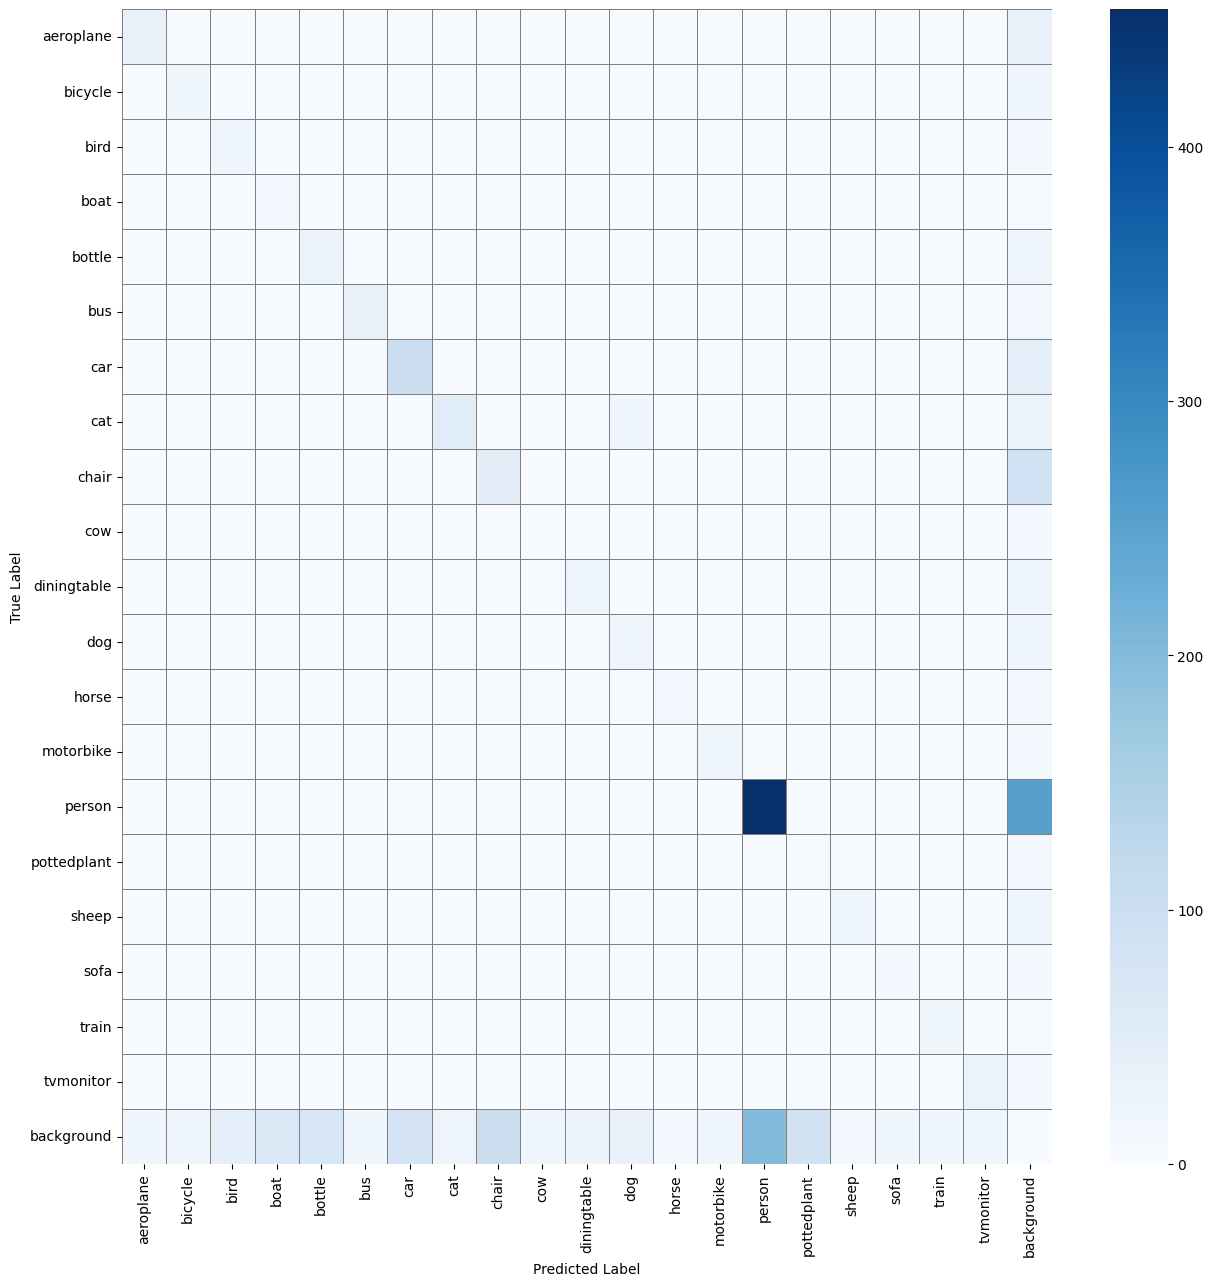

In [14]:
confusion_matrix = results_after.confusion_matrix.matrix
print("Confusion Matrix shape:", confusion_matrix.shape)
classes = list(results_after.names.values())
print("Number of classes:", len(classes))
if 'background' not in classes:
    classes.append('background')
print("Number of classes:", len(classes))

plt.figure(figsize=(15, 15))
sns.heatmap(confusion_matrix, annot=False, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes, linewidths=0.5, linecolor='gray')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)
plt.show()

## Visualization after training


Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 /content/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 10.9ms
Speed: 2.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


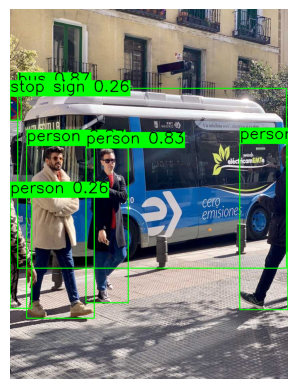

In [15]:
import cv2

results = model_1("https://ultralytics.com/images/bus.jpg")

# Retrieve the first result
result = results[0]

# Retrieve the image with detected bounding boxes
img = result.orig_img

# Define font size and thickness
font_scale = 1.5
font_thickness = 2

# Draw the bounding boxes and labels on the image
for box in result.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    label = result.names[int(box.cls[0])]
    confidence = box.conf[0]

    # Draw bounding box
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Draw label and confidence
    label_text = f"{label} {confidence:.2f}"
    (label_width, label_height), baseline = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
    cv2.rectangle(img, (x1, y1 - label_height - baseline), (x1 + label_width, y1), (0, 255, 0), cv2.FILLED)
    cv2.putText(img, label_text, (x1, y1 - baseline), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), font_thickness)

# Convert the image from BGR to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image with detections
plt.imshow(img_rgb)
plt.axis('off')  # Turn off axis
plt.show()


0: 640x640 1 chair, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


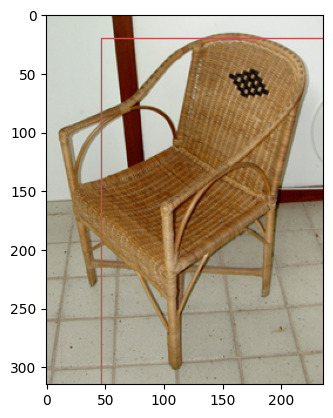


0: 640x640 4 persons, 1 train, 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


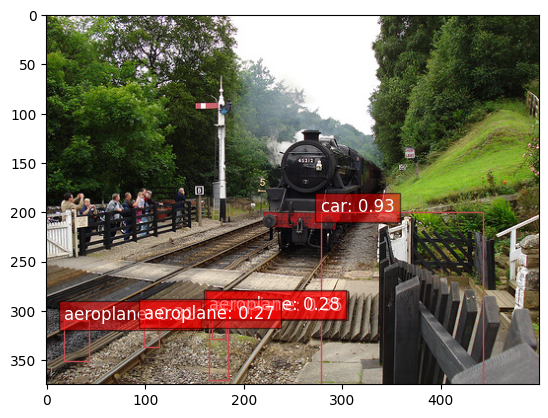


0: 640x640 5 persons, 1 horse, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


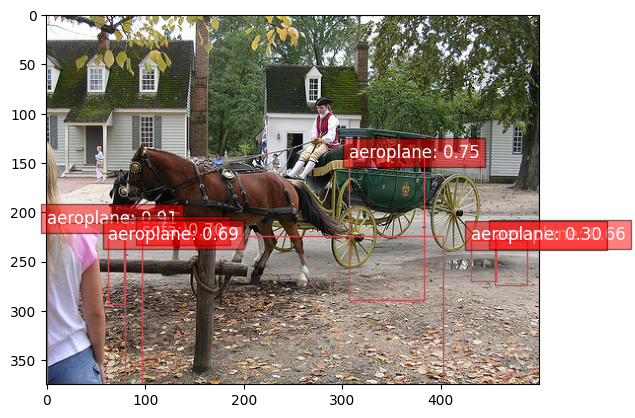


0: 640x640 1 person, 1 chair, 1 couch, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


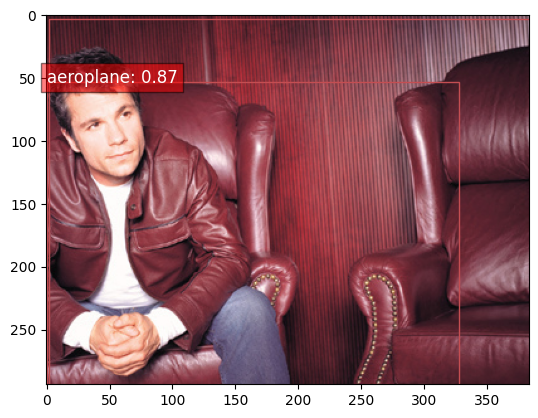


0: 640x640 1 bird, 9.9ms
Speed: 0.0ms preprocess, 9.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


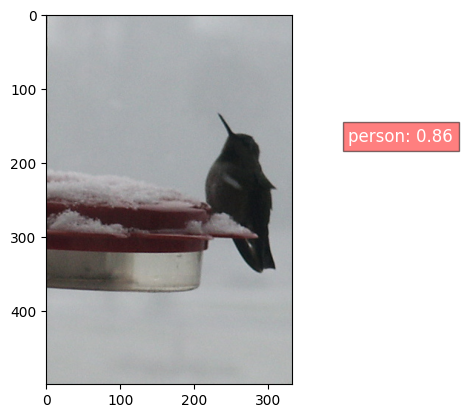

In [16]:
import matplotlib.patches as patches
import random

def visualize_detection(image, results, categories):
    fig, ax = plt.subplots(1)
    ax.imshow(image.permute(1, 2, 0))

    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy()  # Bounding box coordinates
        scores = result.boxes.conf.cpu().numpy()  # Confidence scores
        labels = result.boxes.cls.cpu().numpy()  # Class labels

        for i, box in enumerate(boxes):
            xmin, ymin, xmax, ymax = box
            width = xmax - xmin
            height = ymax - ymin
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            if int(labels[i]) < len(categories):
                category = categories[int(labels[i])]
                plt.text(xmin, ymin, f'{category}: {scores[i]:.2f}', color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.show()

num_images = 5  # Number of images to visualize
indices = random.sample(range(len(test_set)), num_images)
images = [test_set[i][0] for i in indices]

resize_transform = T.Resize((640, 640))

# Make predictions and visualize them
for image in images:
    resized_image = resize_transform(image).unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')
    results = model_1(resized_image)
    visualize_detection(image, results, class_names)

# Model : FasterRCNN

In [ ]:
# Load the pretrained Faster R-CNN model
model_2 = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Set the model to evaluation mode
model_2.eval()

# Number of classes in the Pascal VOC dataset (20 classes + background)
num_classes = 21

# Get the input features of the classifier
in_features = model_2.roi_heads.box_predictor.cls_score.in_features

# Replace the head of the model
model_2.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Freeze all the layers in the backbone
for param in model_2.backbone.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 75.1MB/s]


# Prediction

## Getting dataloaders

In [ ]:
# Define a custom collate function
def collate_fn(batch):
    return tuple(zip(*batch))

def get_dataloaders(train_set, test_set, transform, subset_size, val_size, batch_size):
    train_set.dataset.transform = transform
    test_set.dataset.transform = transform
    if subset_size:
        indices = torch.randperm(len(train_set))[:subset_size]
        train_subset = Subset(train_set, indices)
        train_size = int((1 - val_size) * subset_size)
        val_size = subset_size - train_size
        train_set, val_set = random_split(train_subset, [train_size, val_size])
    else:
        train_size = int((1 - val_size) * len(train_set))
        val_size = len(train_set) - train_size
        train_set, val_set = random_split(train_set, [train_size, val_size])

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)

    return train_loader, val_loader, test_loader

# Function to extract bounding boxes from target
def extract_boxes(target):
    boxes = []
    for obj in target['annotation']['object']:
        box = obj['bndbox']
        boxes.append([int(box['xmin']), int(box['ymin']), int(box['xmax']), int(box['ymax'])])
    return boxes

def visualize_predictions(image, target, prediction):

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Ground truth
    ax[0].imshow(F.to_pil_image(image))
    for i, box in enumerate(extract_boxes(target)):
        ax[0].add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                      fill=False, color='blue', linewidth=2))

        category_name = target['annotation']['object'][i]['name']
        ax[0].text(box[0], box[1] - 10, category_name, color='blue', fontsize=12, backgroundcolor='white')

    ax[0].set_title("Ground Truth")

    # Predictions
    ax[1].imshow(F.to_pil_image(image))
    for i, box in enumerate(prediction['boxes']):
        ax[1].add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                      fill=False, color='red', linewidth=2))

        category_id = prediction['labels'][i].item()
        category_name = categories[category_id]
        ax[1].text(box[0], box[1] - 10, category_name, color='red', fontsize=12)

    ax[1].set_title("Predictions")

    plt.show()

In [ ]:
# Define the transform
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
subset_size = 1000
val_size = 0.2

train_loader, val_loader, test_loader = get_dataloaders(
                                            train_set = train_set,
                                            test_set = test_set,
                                            transform = transform,
                                            subset_size = subset_size,
                                            val_size = val_size,
                                            batch_size = 8)

## Evaluation before training

In [ ]:
# Function to apply NMS and filter predictions
def apply_nms(predictions, iou_threshold=0.5):
    # Perform Non-Maximum Suppression
    keep_indices = torchvision.ops.nms(predictions['boxes'], predictions['scores'], iou_threshold)
    predictions['boxes'] = predictions['boxes'][keep_indices]
    predictions['scores'] = predictions['scores'][keep_indices]
    predictions['labels'] = predictions['labels'][keep_indices]
    return predictions

def calculate_iou(box1, box2):
    # Calculate the (x, y)-coordinates of the intersection rectangle
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Compute the area of both the prediction and ground-truth rectangles
    box1Area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2Area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # Compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = interArea / float(box1Area + box2Area - interArea)

    return iou

def evaluate_model(model, data_loader, device, iou_threshold, eval_batches):
    model.eval()
    total_true_positives = 0
    total_false_positives = 0
    total_false_negatives = 0
    batch_count = 0

    with torch.no_grad():
        for images, targets in data_loader:

            if batch_count >= eval_batches:
                break

            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) if torch.is_tensor(v) else v for k, v in t.items()} for t in targets]

            # Make predictions
            predictions = model(images)

            for i in range(len(predictions)):
                # Apply NMS
                predictions[i] = apply_nms(predictions[i], iou_threshold)

                # Evaluate predictions
                pred_boxes = predictions[i]['boxes'].cpu()
                true_boxes = extract_boxes(targets[i])

                # Calculate true positives, false positives, false negatives
                for pred_box in pred_boxes:
                    if any([calculate_iou(pred_box, true_box) > iou_threshold for true_box in true_boxes]):
                        total_true_positives += 1
                    else:
                        total_false_positives += 1
                total_false_negatives += len(true_boxes) - total_true_positives

            print(f"{batch_count} / {eval_batches}")
            batch_count += 1

    precision = total_true_positives / (total_true_positives + total_false_positives)
    recall = total_true_positives / (total_true_positives + total_false_negatives)

    return precision, recall

In [ ]:
device = torch.device('cpu')
model_2.to(device)

precision_before, recall_before = evaluate_model(model_2, test_loader, device, iou_threshold=0.5, eval_batches=5)
print(f"Precision before training: {precision_before:.4f}, Recall before training: {recall_before:.4f}")


## Visualization before training

In [ ]:
device = torch.device('cpu')
model_2.to(device)

model_2.eval()
with torch.no_grad():
    for images, targets in test_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) if torch.is_tensor(v) else v for k, v in t.items()} for t in targets]

        # Make predictions
        predictions = model_2(images)

        # Apply NMS to the first image's predictions
        predictions[0] = apply_nms(predictions[0], iou_threshold=0.5)

        # Visualize predictions for the first image in the batch
        visualize_predictions(images[0], targets[0], predictions[0])

        # Stop after a few examples
        break

In [ ]:
import torch
import torchvision.transforms as T
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ultralytics import YOLO

def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    return img

def preprocess_image(image):
    transform = T.Compose([
        T.Resize((640, 640)),
        T.ToTensor()
    ])
    return transform(image).unsqueeze(0)

# Load and preprocess the image
url = "https://ultralytics.com/images/bus.jpg"
original_image = load_image_from_url(url)
input_image = preprocess_image(original_image)

def visualize_detection(image, prediction, categories):
    fig, ax = plt.subplots(1)
    ax.imshow(image.permute(1, 2, 0))

    boxes = prediction['boxes'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()

    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        if int(labels[i]) < len(categories):
            category = categories[int(labels[i])]
            plt.text(xmin, ymin, f'{category}: {scores[i]:.2f}', color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.show()

model_2.eval()
with torch.no_grad():

    # Make predictions
    predictions = model_2(input_image)

    # Visualize predictions
    visualize_detection(input_image[0].cpu(), predictions[0], categories)

## Training

In [ ]:
# Function to extract boxes and labels from target

def get_boxes_and_labels(target):
    boxes = []
    labels = []
    class_to_idx = {cls: idx for idx, cls in enumerate(categories)}
    for obj in target['annotation']['object']:
        box = obj['bndbox']
        boxes.append([int(box['xmin']), int(box['ymin']), int(box['xmax']), int(box['ymax'])])
        labels.append(class_to_idx[obj['name']])
    return {
        "boxes": torch.as_tensor(boxes, dtype=torch.float32),
        "labels": torch.as_tensor(labels, dtype=torch.int64)
    }

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_2.to(device)

# Define training parameters
num_epochs = 10
learning_rate = 0.005
weight_decay = 0.0005

# Set up the optimizer
params = [p for p in model_2.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=weight_decay)

# Set up the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler

# Training loop
loss_list = []
for epoch in range(num_epochs):
    model_2.train()
    i = 0
    epoch_loss = 0
    for images, targets in train_loader:
        # Move data to the appropriate device
        images = [image.to(device) for image in images]
        targets = [get_boxes_and_labels(t) for t in targets]
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model_2(images, targets)

        # Compute losses
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()

        if i % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 10}/{len(train_loader)}], Loss: {losses.item():.4f}")
        i += 1

    loss_list.append(epoch_loss / len(train_loader))
    # Update the learning rate
    lr_scheduler.step()
    torch.cuda.empty_cache()

print("Training complete.")

## Evaluation after training

In [ ]:
device = torch.device('cpu')
model_2.to(device)

precision_before, recall_before = evaluate_model(model_2, test_loader, device, iou_threshold=0.5, eval_batches=5)
print(f"Precision before training: {precision_before:.4f}, Recall before training: {recall_before:.4f}")


In [ ]:
device = torch.device('cpu')
model_2.to(device)

precision_after, recall_after = evaluate_model(model_2, test_loader, device, iou_threshold=0.5, eval_batches=5)
print(f"Precision after training: {precision_after:.4f}, Recall after training: {recall_after:.4f}")

## Visualization after training

In [ ]:
model_2.eval()
with torch.no_grad():
    for images, targets in test_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) if torch.is_tensor(v) else v for k, v in t.items()} for t in targets]

        # Make predictions
        predictions = model_2(images)

        # Apply NMS to the first image's predictions
        predictions[0] = apply_nms(predictions[0], iou_threshold=0.8)

        # Visualize predictions for the first image in the batch
        visualize_predictions(images[0], targets[0], predictions[0])

        # Stop after a few examples
        break

In [ ]:
model_2.eval()
with torch.no_grad():
    for images, targets in test_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) if torch.is_tensor(v) else v for k, v in t.items()} for t in targets]

        # Make predictions
        predictions = model_2(images)

        # Apply NMS to the first image's predictions
        predictions[0] = apply_nms(predictions[0], iou_threshold=0.1)

        # Visualize predictions for the first image in the batch
        visualize_predictions(images[0], targets[0], predictions[0])

        # Stop after a few examples
        break

In [ ]:
model_2.eval()
with torch.no_grad():
    for images, targets in test_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) if torch.is_tensor(v) else v for k, v in t.items()} for t in targets]

        # Make predictions
        predictions = model_2(images)

        # Apply NMS to the first image's predictions
        predictions[0] = apply_nms(predictions[0], iou_threshold=0.95)

        # Visualize predictions for the first image in the batch
        visualize_predictions(images[0], targets[0], predictions[0])

        # Stop after a few examples
        break